In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
import os, gc, math, sys, re
import os,sys
import numpy as np
import logging
import pandas as pd
import time
import threading
import copy as cp

from tqdm import *
from datetime import datetime as dt
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [3]:
log_filename = format(dt.today(), 'log_research-%Y-%m-%d.log')
logging.basicConfig(format='[%(asctime)s]  %(message)s', level=logging.DEBUG,
                    filename=os.path.join('..', log_filename))
logging.info('RESEARCH log file')

In [4]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
matplotlib.rc('font', family='DejaVu Sans')
%matplotlib inline

In [5]:
with open('../preproc_df.pkl', 'rb') as f:
    df = pkl.load(f)

In [6]:
def show_nulls(data):
    d = ((c, data[c][pd.isnull(data[c])].shape[0]) for c in data.columns)
    return pd.DataFrame(d, columns=['name', 'nans'])

In [7]:
def mape(y_true, y_pred):
    x = list(filter(lambda x: x[0] != 0, zip(y_true, y_pred)))
    y_true = [i[0] for i in x]
    y_pred = [i[1] for i in x]
    return np.mean(np.abs((pd.Series(y_true) - pd.Series(y_pred)) / pd.Series(y_true))) * 100.

def quality(true,pred):
    res_df = pd.DataFrame()
    res_df['true'] = true
    res_df['pred'] = pred
    res_df['t-p'] = res_df['true'] - res_df['pred']
    res_df['t-p'] = list(map(lambda x: abs(x), res_df['t-p']))
    res_df = res_df[res_df['true'] != 0]
    return np.mean(res_df['t-p'])/np.mean(res_df['true'])

    

In [8]:
features = list(df.columns[14:19]) + list(df.columns[22:])
target = 'time_of_expected'

In [9]:
print min(df.Arrive), ' - ', max(df.Arrive)
print min(df[map(lambda x: x.year == 2015, df.Arrive)].Arrive), ' - ', max(df[map(lambda x: x.year == 2015, df.Arrive)].Arrive)
print min(df[map(lambda x: x.year != 2015, df.Arrive)].Arrive), ' - ', max(df[map(lambda x: x.year != 2015, df.Arrive)].Arrive)

2014-04-07 06:48:00  -  2016-11-16 16:20:49
2015-01-02 06:58:00  -  2015-04-10 17:49:00
2014-04-07 06:48:00  -  2016-11-16 16:20:49


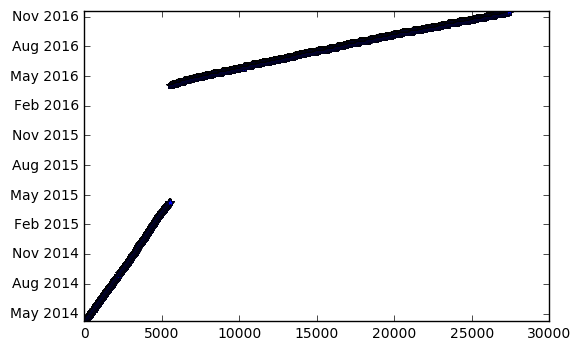

In [10]:
plt.plot(range(df.shape[0]), sorted(df.Arrive), '*')

In [11]:
df = df.sort_values('time_of_expected')
df = df[50:df.shape[0]-50]

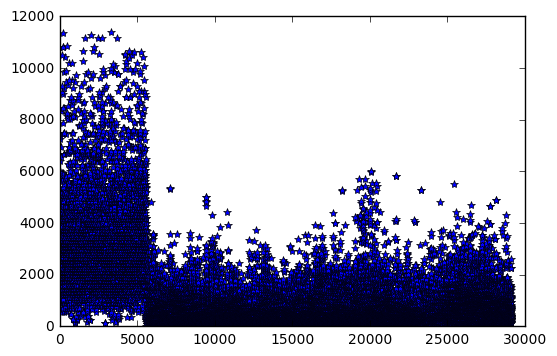

In [12]:
plt.plot(df.time_of_expected, '*')

In [13]:
date_threshold_val_low_1 = datetime.strptime('15.03.2015','%d.%m.%Y')
date_threshold_val_up_1 = datetime.strptime('01.04.2015','%d.%m.%Y')

date_threshold_val_low_2 = datetime.strptime('01.10.2016','%d.%m.%Y')
date_threshold_val_up_2 = datetime.strptime('01.11.2016','%d.%m.%Y')

date_threshold_test_low_1 = datetime.strptime('02.04.2015','%d.%m.%Y')
date_threshold_test_up_1 = datetime.strptime('15.08.2015','%d.%m.%Y')

date_threshold_test_low_2 = datetime.strptime('02.11.2016','%d.%m.%Y')
date_threshold_test_up_2 = datetime.strptime('21.01.2017','%d.%m.%Y')

val_cond = ( (df.Arrive >= date_threshold_val_low_1) & (df.Arrive <= date_threshold_val_up_1) )\
            |\
            ( (df.Arrive >= date_threshold_val_low_2) & (df.Arrive <= date_threshold_val_up_2))
test_cond = ( (df.Arrive >= date_threshold_test_low_1) & (df.Arrive <= date_threshold_test_up_1) )\
            |\
            ( (df.Arrive >= date_threshold_test_low_2) & (df.Arrive <= date_threshold_test_up_2))

test = df[test_cond].reset_index(drop=True)    
val = df[val_cond].reset_index(drop=True)
train = df[map(lambda x,y: not (x or y), test_cond, val_cond)].reset_index(drop=True)

In [14]:
print train.shape[0]
print val.shape[0]
print test.shape[0]

22454
3363
1507


In [15]:
with open('../train_val_test_split.pkl', 'wb') as f:
    pkl.dump([train, val, test], f)

#### Реализуем такие методы, как
##### - последовательное добавление признаков
##### - последовательное вычитание признаков
##### для таких моделей, как LR, LR(Lasso, Ridge), XGBoost, RandomForest

In [17]:
from models import AddFeatures, ExceptFeatures
from sklearn.preprocessing import StandardScaler

In [ ]:
scores_f = {'r2':lambda x,y: -r2_score(x,y),
            'mape':lambda x,y: mape(x,y),
            'mse':lambda x,y: mean_squared_error(x,y),
            'mae':lambda x,y: mean_absolute_error(x,y),
                                          }

In [ ]:
models_add = [AddFeatures(LinearRegression(n_jobs=-1), StandardScaler(), scores_f, 'r2'),
         AddFeatures(Lasso(), StandardScaler(), scores_f, 'r2'),
         AddFeatures(Ridge(), StandardScaler(), scores_f, 'r2'),
         AddFeatures(ElasticNet(), StandardScaler(), scores_f, 'r2'),
         AddFeatures(RandomForestRegressor(n_jobs=-1, max_depth=25, n_estimators=50),
                     StandardScaler(), scores_f, 'r2'),
         AddFeatures(xgb.XGBRegressor(), StandardScaler(), scores_f, 'r2'),
         
         AddFeatures(LinearRegression(n_jobs=-1), StandardScaler(), scores_f, 'mape'),
         AddFeatures(Lasso(), StandardScaler(), scores_f, 'mape'),
         AddFeatures(Ridge(), StandardScaler(), scores_f, 'mape'),
         AddFeatures(ElasticNet(), StandardScaler(), scores_f, 'mape'),
         AddFeatures(RandomForestRegressor(n_jobs=-1, max_depth=25, n_estimators=50),
                     StandardScaler(), scores_f, 'mape'),
         AddFeatures(xgb.XGBRegressor(), StandardScaler(), scores_f, 'mape'),
         ]

In [ ]:
models_except = [ExceptFeatures(LinearRegression(n_jobs=-1), StandardScaler(), scores_f, 'r2'),
         ExceptFeatures(Lasso(), StandardScaler(), scores_f, 'r2'),
         ExceptFeatures(Ridge(), StandardScaler(), scores_f, 'r2'),
         ExceptFeatures(ElasticNet(), StandardScaler(), scores_f, 'r2'),
         ExceptFeatures(RandomForestRegressor(n_jobs=-1, max_depth=25, n_estimators=50), 
                     StandardScaler(), scores_f, 'r2'),
         ExceptFeatures(xgb.XGBRegressor(), StandardScaler(), scores_f, 'r2'),
         
         ExceptFeatures(LinearRegression(n_jobs=-1), StandardScaler(), scores_f, 'mape'),
         ExceptFeatures(Lasso(), StandardScaler(), scores_f, 'mape'),
         ExceptFeatures(Ridge(), StandardScaler(), scores_f, 'mape'),
         ExceptFeatures(ElasticNet(), StandardScaler(), scores_f, 'mape'),
         ExceptFeatures(RandomForestRegressor(n_jobs=-1, max_depth=25, n_estimators=50), 
                     StandardScaler(), scores_f, 'mape'),
         ExceptFeatures(xgb.XGBRegressor(), StandardScaler(), scores_f, 'mape'),
         ]

In [ ]:
def f_train(M, train, val, features, target, ind, results):
    m = M
    sys.stderr.write('{}/{} is started!\n'.format(M.main_name, M.name))
    m.fit(cp.deepcopy(train), cp.deepcopy(val), cp.deepcopy(features), cp.deepcopy(target))
    sys.stderr.write('{}/{} is started!\n'.format(M.main_name, M.name))
    results[ind] = m

m = AddFeatures(LinearRegression(), StandardScaler(), scores_f, 'r2')

m.fit(cp.deepcopy(train.loc[:100, :]),
                cp.deepcopy(val.loc[:100, :]),
                cp.deepcopy(features[:]),
                cp.deepcopy(target)
                 )

In [ ]:
results = [None]*len(models_add+models_except)

threads = [None]*len(models_add+models_except)

for ind, model in enumerate(models_add+models_except):
    threads[ind] = threading.Thread(target=f_train,
                                    name="proc_main_"+str(ind),
                                    args=[cp.deepcopy(model),
                                          cp.deepcopy(train),
                                          cp.deepcopy(val),
                                          cp.deepcopy(features), 
                                          cp.deepcopy(target), 
                                          ind, 
                                          results])
    threads[ind].start()

for ind in range(len(threads)):
    threads[ind].join()

results = [None]*len(models_add+models_except)

for ind, model in tqdm(enumerate(models_add+models_except)):
        print ind
        model.fit(cp.deepcopy(train.loc[:, :]),
                cp.deepcopy(val.loc[:, :]),
                cp.deepcopy(features[:]),
                cp.deepcopy(target)
                 )
        model.scores_f = None
        results[ind] = model
        with open('../result_{}.pkl'.format(str(ind)), 'wb') as f:
            pkl.dump(results, f)

fit_models_add_r2 = []
for m in tqdm(models_add):
    temp_model = m
    temp_model.fit(train, val, features, target, lambda x,y: -r2_score(x,y))
    fit_models_add_r2.append(temp_model)

fit_models_add_mape = []
for m in tqdm(models_add):
    temp_model = m
    temp_model.fit(train, val, features, target, lambda x,y: mape(x,y))
    fit_models_add_mape.append(temp_model)

with open('../fit_models_add_r2.pkl', 'wb') as f:
    pkl.dump(fit_models_add_r2, f)
with open('../fit_models_add_mape.pkl', 'wb') as f:
    pkl.dump(fit_models_add_mape,f)

fit_models_except_r2 = []
for m in tqdm(models_except):
    temp_model = m
    temp_model.fit(train, val, features, target, lambda x,y: -r2_score(x,y))
    fit_models_except_r2.append(temp_model)

fit_models_except_mape = []
for m in tqdm(models_except):
    temp_model = m
    temp_model.fit(train, val, features, target, lambda x,y: mape(x,y))
    fit_models_except_mape.append(temp_model)

with open('../fit_models_except_r2.pkl', 'wb') as f:
    pkl.dump(fit_models_except_r2, f)
with open('../fit_models_except_mape.pkl', 'wb') as f:
    pkl.dump(fit_models_except_mape,f)

____